In [2]:
import pandas as pd

# Specify the file paths
file_path_benchmark = 'tech_benchmark.xlsx'  # Benchmark file path
file_path_portfolio = 'portfolio_daily_returns.xlsx'  # Portfolio file path

# Process the benchmark file
df_benchmark = pd.read_excel(file_path_benchmark, header=0)  # Use the first row as the header
df_benchmark = df_benchmark.iloc[:, :2]  # Select only the first two columns
df_benchmark.columns = ['Date', 'Prices']  # Rename columns for clarity
df_benchmark.set_index('Date', inplace=True)  # Set the 'Date' column as the index

# Reverse the order of the DataFrame to ensure chronological order
df_benchmark = df_benchmark.iloc[::-1]

# Calculate daily returns
df_benchmark['Returns'] = df_benchmark['Prices'].pct_change()  # Calculate daily returns
df_benchmark.dropna(inplace=True)  # Drop rows with NaN values

# Process the portfolio file
df_port = pd.read_excel(file_path_portfolio, header=0)  # Use the first row as the header
df_port = df_port.iloc[:, :2]  # Select only the first two columns
df_port.columns = ['Date', 'Returns']  # Rename columns for clarity
df_port.set_index('Date', inplace=True)  # Set the 'Date' column as the index

# Define the start date for alignment
start_date = pd.to_datetime('2017-01-31')

# Create a common date range starting from the specified date
common_index = pd.date_range(start=start_date, end=max(df_port.index[-1], df_benchmark.index[-1]))

# Reindex both series to the common date range, filling missing values with zero
portfolio_aligned = df_port['Returns'].reindex(common_index, fill_value=0)
benchmark_aligned = df_benchmark['Returns'].reindex(common_index, fill_value=0)

# Save the aligned data to an Excel file
aligned_data = pd.DataFrame({
    'Portfolio Returns': portfolio_aligned,
    'Benchmark Returns': benchmark_aligned
})
aligned_data.to_excel("aligned_returns.xlsx")

print("Aligned returns saved to 'aligned_returns.xlsx'.")


Aligned returns saved to 'aligned_returns.xlsx'.


In [3]:
import numpy as np
# Parameters
risk_free_rate = 0 / 252  # Annualized risk-free rate, divided by 252 trading days

# Function to calculate the Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

# Function to calculate the Treynor Ratio
def treynor_ratio(returns, benchmark_returns, risk_free_rate):
    beta = np.cov(returns, benchmark_returns)[0, 1] / np.var(benchmark_returns)
    return (np.mean(returns) - risk_free_rate) / beta

# Function to calculate the Sortino Ratio
def sortino_ratio(returns, risk_free_rate, mar=0):
    downside_returns = returns[returns < mar]
    downside_deviation = np.sqrt(np.mean(downside_returns ** 2))
    excess_returns = np.mean(returns - risk_free_rate)
    return excess_returns / downside_deviation

# Function to calculate the Information Ratio
def information_ratio(returns, benchmark_returns):
    active_return = returns - benchmark_returns
    tracking_error = np.std(active_return)
    return np.mean(active_return) / tracking_error

# Function to calculate the Tracking Error
def tracking_error(returns, benchmark_returns):
    return np.std(returns - benchmark_returns)

# Function to calculate Jensen's Alpha
def jensen_alpha(returns, benchmark_returns, risk_free_rate):
    beta = np.cov(returns, benchmark_returns)[0, 1] / np.var(benchmark_returns)
    expected_portfolio_return = risk_free_rate + beta * (np.mean(benchmark_returns) - risk_free_rate)
    return np.mean(returns) - expected_portfolio_return

# Function to calculate the Maximum Drawdown
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Function to calculate Upside and Downside Capture Ratios
def capture_ratio(returns, benchmark_returns):
    up_capture = np.mean(returns[benchmark_returns > 0]) / np.mean(benchmark_returns[benchmark_returns > 0])
    down_capture = np.mean(returns[benchmark_returns < 0]) / np.mean(benchmark_returns[benchmark_returns < 0])
    return up_capture, down_capture, up_capture / down_capture

sharpe = sharpe_ratio(portfolio_aligned, risk_free_rate)
treynor = treynor_ratio(portfolio_aligned, benchmark_aligned, risk_free_rate)
sortino = sortino_ratio(portfolio_aligned, risk_free_rate)
information = information_ratio(portfolio_aligned, benchmark_aligned)
track_error = tracking_error(portfolio_aligned, benchmark_aligned)
alpha = jensen_alpha(portfolio_aligned, benchmark_aligned, risk_free_rate)
mdd = max_drawdown(portfolio_aligned)
up_capture, down_capture, capture_ratio_value = capture_ratio(portfolio_aligned, benchmark_aligned)

# Displaying the results
print(f"Sharpe Ratio: {sharpe}")
print(f"Treynor Ratio: {treynor}")
print(f"Sortino Ratio: {sortino}")
print(f"Information Ratio: {information}")
print(f"Tracking Error: {track_error}")
print(f"Jensen's Alpha: {alpha}")
print(f"Maximum Drawdown: {mdd}")
print(f"Upside Capture: {up_capture}, Downside Capture: {down_capture}, Capture Ratio: {capture_ratio_value}")


Sharpe Ratio: 0.04126621620526521
Treynor Ratio: 0.0006319438452499853
Sortino Ratio: 0.03144559436826663
Information Ratio: -0.005698175069564379
Tracking Error: 0.010109819650836526
Jensen's Alpha: -0.0001902351992376318
Maximum Drawdown: -0.3762980211669943
Upside Capture: 1.2354007218971228, Downside Capture: 1.317805495290667, Capture Ratio: 0.9374681819980055


In [4]:
def rolling_sharpe(returns, risk_free_rate, window):
    """
    Calculate rolling Sharpe ratio.
    
    :param returns: Series of portfolio returns
    :param risk_free_rate: Constant risk-free rate (or a series of risk-free rates)
    :param window: Rolling window size (in periods)
    :return: Series of Sharpe ratios
    """
    excess_returns = returns - risk_free_rate
    rolling_sharpe_ratio = excess_returns.rolling(window=window).mean() / excess_returns.rolling(window=window).std()
    return rolling_sharpe_ratio

def rolling_information_ratio(returns_portfolio, returns_benchmark, window):
    """
    Calculate rolling Information ratio.
    
    :param returns_portfolio: Series of portfolio returns
    :param returns_benchmark: Series of benchmark returns
    :param window: Rolling window size (in periods)
    :return: Series of Information ratios
    """
    excess_returns = returns_portfolio - returns_benchmark
    tracking_error = excess_returns.rolling(window=window).std()
    rolling_info_ratio = excess_returns.rolling(window=window).mean() / tracking_error
    return rolling_info_ratio

def rolling_sortino_ratio(returns, risk_free_rate, window):
    """
    Calculate rolling Sortino ratio.
    
    :param returns: Series of portfolio returns
    :param risk_free_rate: Constant risk-free rate (or a series of risk-free rates)
    :param window: Rolling window size (in periods)
    :return: Series of Sortino ratios
    """
    excess_returns = returns - risk_free_rate
    downside_returns = returns[returns < 0]
    downside_volatility = downside_returns.rolling(window=window).std()
    rolling_sortino = excess_returns.rolling(window=window).mean() / downside_volatility
    return rolling_sortino

def calculate_drawdowns(returns):
    """
    Calculate drawdowns and maximum drawdown.
    
    :param returns: Series of portfolio returns
    :return: DataFrame with drawdowns and max drawdown
    """
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()  # Maximum drawdown
    return drawdown, max_drawdown





Max Drawdown: -0.3762980211669943


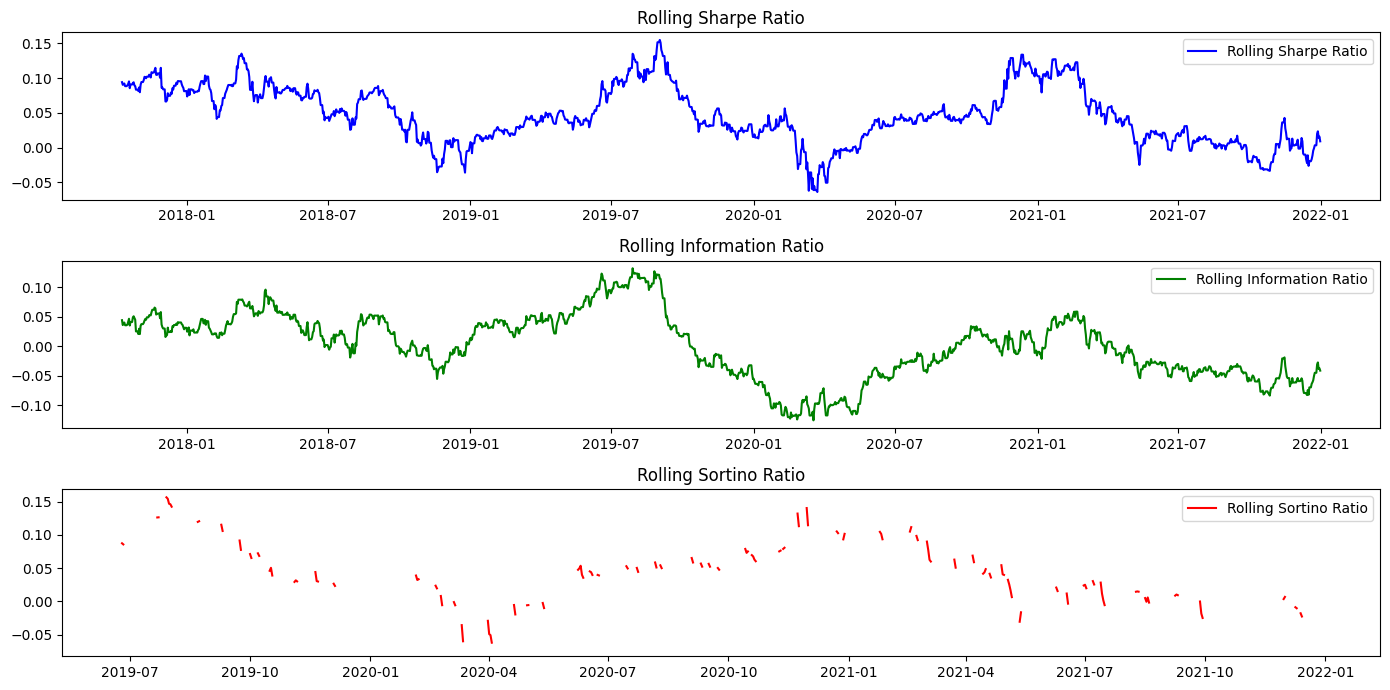

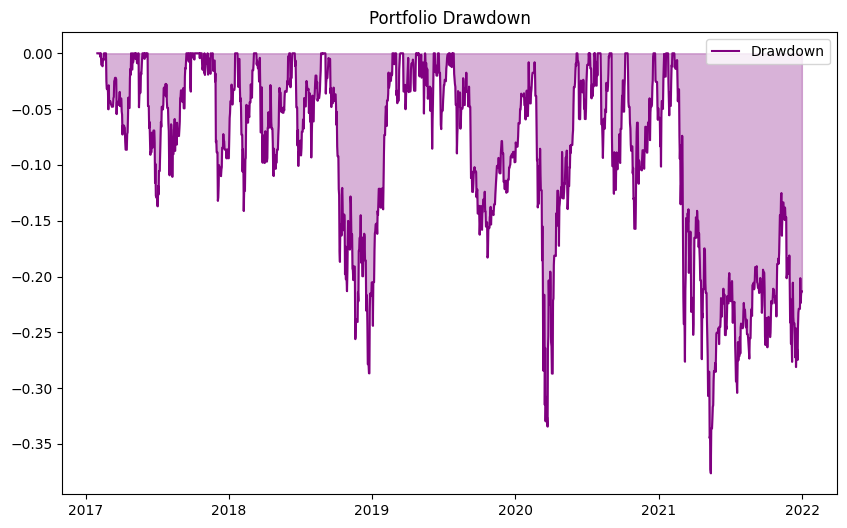

In [5]:
import matplotlib.pyplot as plt
window_size=252


rolling_sharpe_values = rolling_sharpe(portfolio_aligned, risk_free_rate, window_size)
rolling_info_values = rolling_information_ratio(portfolio_aligned, benchmark_aligned, window_size)
rolling_sortino_values = rolling_sortino_ratio(portfolio_aligned, risk_free_rate, window_size)

# Calculate drawdowns and max drawdown
drawdown_values, max_drawdown_value = calculate_drawdowns(portfolio_aligned)

# Display results
print("Max Drawdown:", max_drawdown_value)

# Plot Rolling Sharpe Ratio, Information Ratio, and Sortino Ratio
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(rolling_sharpe_values, label='Rolling Sharpe Ratio', color='blue')
plt.title('Rolling Sharpe Ratio')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(rolling_info_values, label='Rolling Information Ratio', color='green')
plt.title('Rolling Information Ratio')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(rolling_sortino_values, label='Rolling Sortino Ratio', color='red')
plt.title('Rolling Sortino Ratio')
plt.legend()

plt.tight_layout()
plt.show()

# Plot drawdowns
plt.figure(figsize=(10, 6))
plt.plot(drawdown_values, label='Drawdown', color='purple')
plt.title('Portfolio Drawdown')
plt.fill_between(drawdown_values.index, drawdown_values, color='purple', alpha=0.3)
plt.legend()
plt.show()

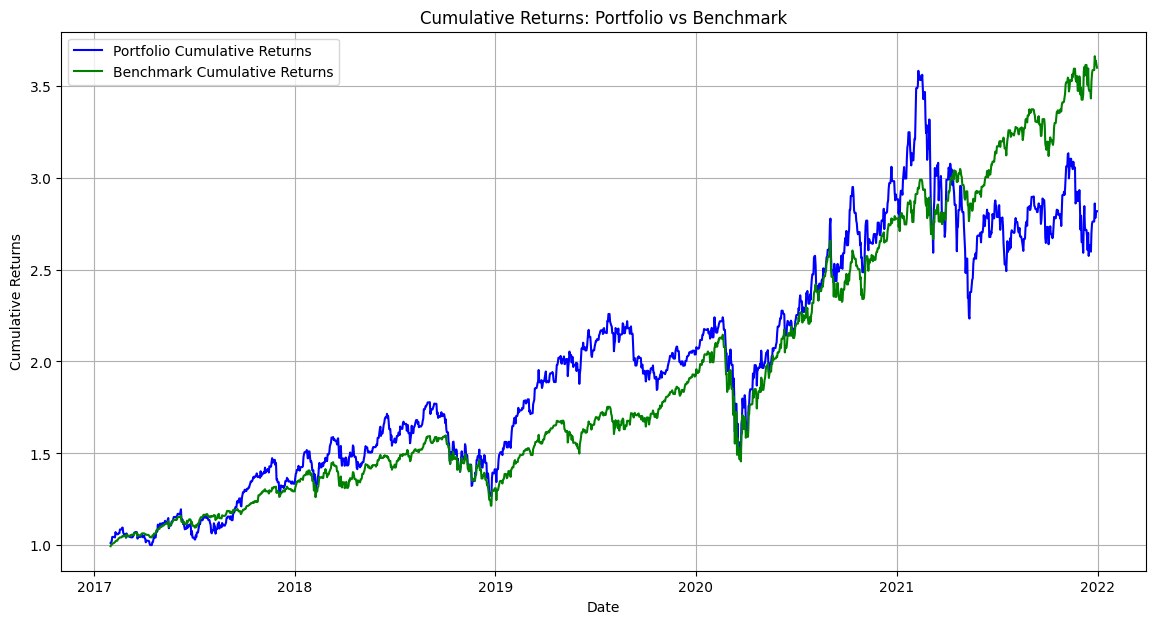

In [6]:

# Calculate cumulative returns for the portfolio and the benchmark
cumulative_portfolio_returns = (1 + portfolio_aligned).cumprod()
cumulative_benchmark_returns = (1 + benchmark_aligned).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_portfolio_returns, label='Portfolio Cumulative Returns', color='blue')
plt.plot(cumulative_benchmark_returns, label='Benchmark Cumulative Returns', color='green')
plt.title('Cumulative Returns: Portfolio vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# RISK MEASURE


In [8]:
def historical_var(returns, portfolio_value, confidence_level=0.95):
    """
    Calculate Historical VaR in monetary terms.
    
    :param returns: Series of portfolio returns
    :param portfolio_value: Total value of the portfolio (e.g., 100 million USD)
    :param confidence_level: Confidence level for VaR (e.g., 0.95 for 95% VaR)
    :return: VaR in monetary terms
    """
    var_percent = np.percentile(returns, (1 - confidence_level) * 100)
    var_monetary = portfolio_value * abs(var_percent)  # Convert percentage to monetary
    return var_monetary


 
def parametric_var(returns, portfolio_value, confidence_level=0.95):
    """
    Calculate Parametric (Gaussian) VaR in monetary terms.
    
    :param returns: Series of portfolio returns
    :param portfolio_value: Total value of the portfolio (e.g., 100 million USD)
    :param confidence_level: Confidence level for VaR (e.g., 0.95 for 95% VaR)
    :return: VaR in monetary terms
    """
    mean = returns.mean()
    std_dev = returns.std()
    
    # Z-score for the confidence level (e.g., 1.645 for 95% VaR)
    z = abs(np.percentile(np.random.randn(10000), (1 - confidence_level) * 100))
    
    # Calculate VaR as a percentage of the portfolio
    var_percent = mean - z * std_dev
    
    # Convert to monetary value
    var_monetary = portfolio_value * abs(var_percent)
    
    return var_monetary

def monte_carlo_var(returns, portfolio_value, confidence_level=0.95, num_simulations=10000):
    """
    Calculate Monte Carlo VaR in monetary terms.
    
    :param returns: Series of portfolio returns
    :param portfolio_value: Total value of the portfolio (e.g., 100 million USD)
    :param confidence_level: Confidence level for VaR (e.g., 0.95 for 95% VaR)
    :param num_simulations: Number of simulations for Monte Carlo
    :return: VaR in monetary terms
    """
    mean = returns.mean()
    std_dev = returns.std()
    
    # Simulate returns based on the portfolio's historical mean and standard deviation
    simulated_returns = np.random.normal(mean, std_dev, num_simulations)
    
    # Calculate VaR as a percentage of the portfolio
    var_percent = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    # Convert to monetary value
    var_monetary = portfolio_value * abs(var_percent)
    
    return var_monetary



In [13]:
confidence_level = 0.95  # 95% confidence level
value=100
# Calculate Historical VaR
historical_var_value = historical_var(portfolio_aligned, value, confidence_level)
parametric_var_value = parametric_var(portfolio_aligned,value, confidence_level)
monte_carlo_var_value = monte_carlo_var(portfolio_aligned, value, confidence_level)

print(f"Historical VaR: ${historical_var_value:,.2f} million")
print(f"Parametric VaR: ${parametric_var_value:,.2f} million")
print(f"Monte Carlo VaR: ${monte_carlo_var_value:,.2f} million")

Historical VaR: $3.03 million
Parametric VaR: $2.81 million
Monte Carlo VaR: $2.86 million


In [12]:
def historical_es(returns, portfolio_value, confidence_level=0.95):
    """
    Calcola l'Expected Shortfall (ES) usando un approccio storico in termini monetari.
    
    :param returns: Serie di rendimenti del portafoglio
    :param portfolio_value: Valore totale del portafoglio (ad esempio, 100 milioni USD)
    :param confidence_level: Livello di confidenza (es. 0.95 per il 95% ES)
    :return: ES in termini monetari
    """
    # Calcola il VaR storico
    var_percent = np.percentile(returns, (1 - confidence_level) * 100)
    
    # Calcola l'Expected Shortfall come la media delle perdite oltre il VaR
    expected_shortfall_percent = returns[returns <= var_percent].mean()
    
    # Converti in valore monetario
    es_monetary = portfolio_value * abs(expected_shortfall_percent)
    
    return es_monetary

def parametric_es(returns, portfolio_value, confidence_level=0.95):
    """
    Calcola l'Expected Shortfall (ES) usando un approccio parametrico (gaussiano) in termini monetari.
    
    :param returns: Serie di rendimenti del portafoglio
    :param portfolio_value: Valore totale del portafoglio (ad esempio, 100 milioni USD)
    :param confidence_level: Livello di confidenza (es. 0.95 per il 95% ES)
    :return: ES in termini monetari
    """
    mean = returns.mean()
    std_dev = returns.std()
    
    # Z-score per il livello di confidenza (ad esempio, Z=1.645 per il 95%)
    z = abs(np.percentile(np.random.randn(10000), (1 - confidence_level) * 100))
    
    # Calcola il VaR parametrico
    var_percent = mean - z * std_dev
    
    # Expected Shortfall per una distribuzione normale
    es_percent = mean - (std_dev * (np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi) * (1 - confidence_level))))
    
    # Converti in valore monetario
    es_monetary = portfolio_value * abs(es_percent)
    
    return es_monetary

def monte_carlo_es(returns, portfolio_value, confidence_level=0.95, num_simulations=10000):
    """
    Calcola l'Expected Shortfall (ES) usando un approccio Monte Carlo in termini monetari.
    
    :param returns: Serie di rendimenti del portafoglio
    :param portfolio_value: Valore totale del portafoglio (ad esempio, 100 milioni USD)
    :param confidence_level: Livello di confidenza (es. 0.95 per il 95% ES)
    :param num_simulations: Numero di simulazioni per Monte Carlo
    :return: ES in termini monetari
    """
    mean = returns.mean()
    std_dev = returns.std()
    
    # Simuliamo i rendimenti basati sulla media e la deviazione standard storica
    simulated_returns = np.random.normal(mean, std_dev, num_simulations)
    
    # Calcoliamo il VaR per i rendimenti simulati
    var_percent = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    # Calcoliamo l'Expected Shortfall come la media dei rendimenti peggiori del VaR
    expected_shortfall_percent = simulated_returns[simulated_returns <= var_percent].mean()
    
    # Converti in valore monetario
    es_monetary = portfolio_value * abs(expected_shortfall_percent)
    
    return es_monetary



In [14]:
historical_es_value = historical_es(portfolio_aligned, value, confidence_level)
parametric_es_value = parametric_es(portfolio_aligned, value, confidence_level)
monte_carlo_es_value = monte_carlo_es(portfolio_aligned, value, confidence_level)

print(f"Historical ES: ${historical_es_value:,.2f}")
print(f"Parametric ES: ${parametric_es_value:,.2f}")
print(f"Monte Carlo ES: ${monte_carlo_es_value:,.2f}")

Historical ES: $4.59
Parametric ES: $3.55
Monte Carlo ES: $3.63


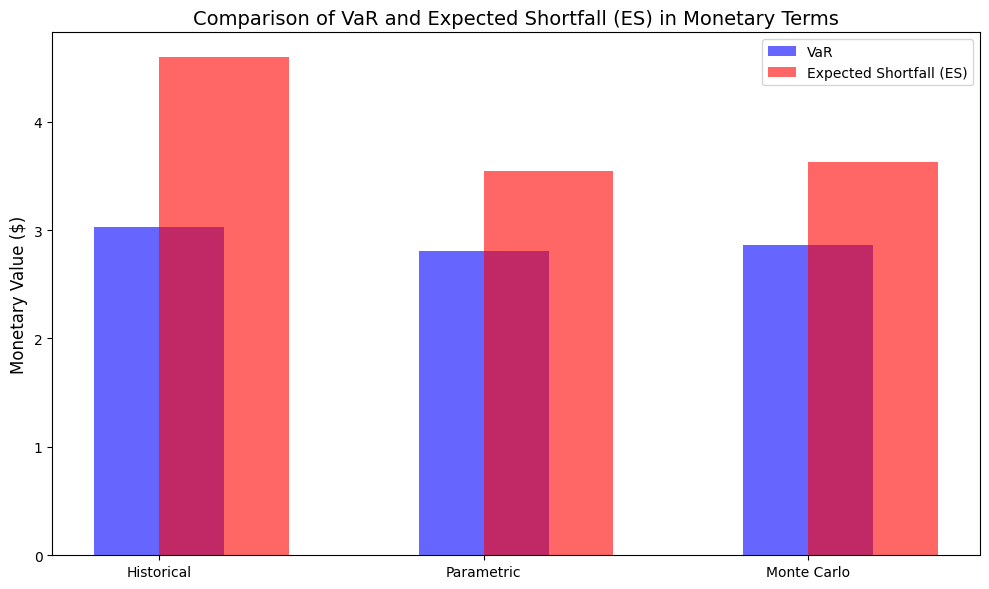

In [15]:
# Create a DataFrame to store and compare the results
results_df = pd.DataFrame({
    'VaR': [historical_var_value, parametric_var_value, monte_carlo_var_value],
    'ES': [historical_es_value, parametric_es_value, monte_carlo_es_value]
}, index=['Historical', 'Parametric', 'Monte Carlo'])

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot VaR values
ax.bar(results_df.index, results_df['VaR'], label='VaR', alpha=0.6, color='blue', width=0.4, align='center')

# Plot ES values slightly shifted to the right for comparison
ax.bar(results_df.index, results_df['ES'], label='Expected Shortfall (ES)', alpha=0.6, color='red', width=0.4, align='edge')

# Customize the plot
ax.set_title('Comparison of VaR and Expected Shortfall (ES) in Monetary Terms', fontsize=14)
ax.set_ylabel('Monetary Value ($)', fontsize=12)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

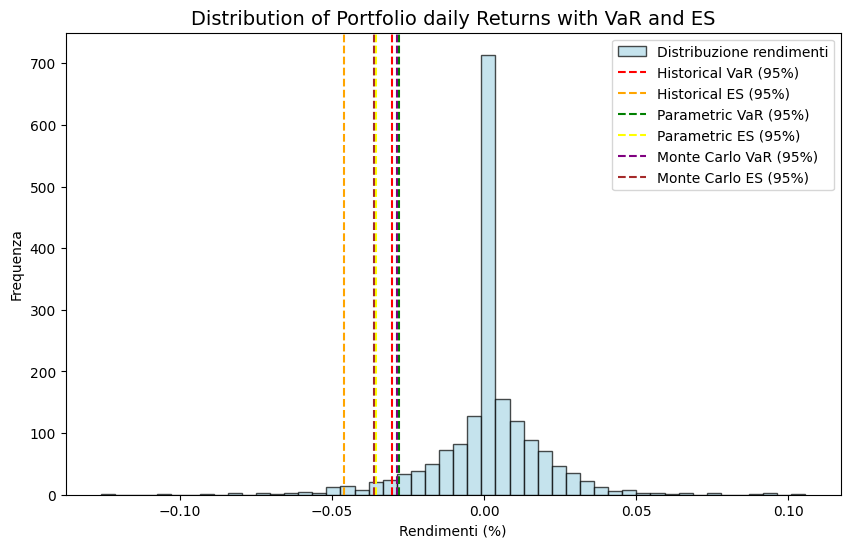

In [16]:
# Normalizza (dividi per il valore del portafoglio) e metti il segno negativo
historical_var_pct = -(historical_var_value / value)
historical_es_pct = -(historical_es_value / value)
parametric_var_pct = -(parametric_var_value / value)
parametric_es_pct = -(parametric_es_value /value)

monte_carlo_var_pct = -(monte_carlo_var_value / value)
monte_carlo_es_pct = -(monte_carlo_es_value / value)
# Creazione del grafico della distribuzione dei rendimenti con i VaR e ES
plt.figure(figsize=(10, 6))

# Istogramma della distribuzione dei rendimenti
plt.hist(portfolio_aligned, bins=50, color='lightblue', edgecolor='black', alpha=0.7, label='Distribuzione rendimenti')

# Linee VaR e ES
plt.axvline(historical_var_pct, color='red', linestyle='--', label=f'Historical VaR ({confidence_level*100:.0f}%)')
plt.axvline(historical_es_pct, color='orange', linestyle='--', label=f'Historical ES ({confidence_level*100:.0f}%)')

plt.axvline(parametric_var_pct, color='green', linestyle='--', label=f'Parametric VaR ({confidence_level*100:.0f}%)')
plt.axvline(parametric_es_pct, color='yellow', linestyle='--', label=f'Parametric ES ({confidence_level*100:.0f}%)')

plt.axvline(monte_carlo_var_pct, color='purple', linestyle='--', label=f'Monte Carlo VaR ({confidence_level*100:.0f}%)')
plt.axvline(monte_carlo_es_pct, color='brown', linestyle='--', label=f'Monte Carlo ES ({confidence_level*100:.0f}%)')

# Personalizzazioni del grafico
plt.title('Distribution of Portfolio daily Returns with VaR and ES', fontsize=14)
plt.xlabel('Rendimenti (%)')
plt.ylabel('Frequenza')
plt.legend()

# Visualizzazione del grafico
plt.show()